In [1]:
import os
import six
import glob
import pickle

import numpy as np
import pandas as pd
import scipy.stats as spst

import argus_shapes
import pulse2percept.implants as p2pi
import pulse2percept.retina as p2pr
import pulse2percept.utils as p2pu

import skimage.io as skio
import skimage.transform as skit

from sklearn.base import clone
import sklearn.metrics as sklm

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)
2018-05-14 13:08:25,776 [pulse2percept] [INFO] Welcome to pulse2percept


# Load data

In [2]:
results_dir = '../../results/shape8cv/'
datafolder = os.environ['ARGUS_SHAPES_DATA']
subjectdata = argus_shapes.load_subjects(os.path.join(datafolder, 'subjects.csv'))
subjectdata['scale'] = pd.Series([0.5, 1.5, 1.0, 0.6], index=subjectdata.index)
subjectdata

,implant_rot,implant_x,implant_y,loc_od_x,loc_od_y,second_sight_id,xrange,yrange,implant_type,scale
subject_id,,,,,,,,,,
S4,-0.457,-1230,415,15.9,1.96,52-001,"(-32.0, 32.0)","(-24.0, 24.0)",<class 'pulse2percept.implants.ArgusII'>,0.5
S3,-1.090,-799,93,15.7,0.75,51-009,"(-32.5, 32.5)","(-24.4, 24.4)",<class 'pulse2percept.implants.ArgusII'>,1.5
S1,-1.130,-1527,-556,13.6,0.00,TB,"(-36.9, 36.9)","(-36.9, 36.9)",<class 'pulse2percept.implants.ArgusI'>,1.0
S2,-0.188,-1761,-212,15.4,1.86,12-005,"(-30.0, 30.0)","(-22.5, 22.5)",<class 'pulse2percept.implants.ArgusII'>,0.6


In [3]:
# subjectdata.index = ['52-001', '51-009', '12-005', 'TB']

In [4]:
subjects = subjectdata.index.sort_values()

In [5]:
def load_data(pickle_files, verbose=True):
    data = []
    for pickle_file in pickle_files:
        if verbose:
            print('- Processing %s' % pickle_file)
        y, y_pred, best_params, specifics = pickle.load(open(pickle_file, 'rb'))
        if isinstance(specifics, list):
            assert np.allclose([s['avg_img'] for s in specifics], True)
            specifics = specifics[0]
        else:
            assert specifics['avg_img']
        if isinstance(y, list):
            y = pd.concat(y)
        if isinstance(y_pred, list):
            y_pred = pd.concat(y_pred)
            
        row = {
            'subject': specifics['subject'],
            'model': specifics['modelname'],
            'exetime': specifics['exetime'],
            'best_train_cost': specifics['best_train_score'][0],
            'idx_fold': specifics['idx_fold'],
            'y_test': y,
            'y_pred': y_pred,
            'n_samples': len(y),
            'n_folds': specifics['n_folds'],
            'filepath': os.path.dirname(pickle_file),
            'filename': os.path.basename(pickle_file)
        }
        [row.update(bp) for bp in best_params]
        data.append(row)
    return pd.DataFrame(data)

In [6]:
def calc_test_cost(grouped_data, verbose=True):
    compact_data = []
    for (subject, model), data in grouped_data:
        if verbose:
            print('- Processing %s, %s %s' % (subject, model, adjust_bias))
        # Aggregate test data from all folds:
#         xyrange = np.array([np.diff(subjectdata.loc[subject, 'xrange'])[0],
#                             np.diff(subjectdata.loc[subject, 'yrange'])[0]])
        y_test = pd.DataFrame([{'image': row['image'].values[0],
                                'img_shape': row['image'].values[0].shape,
                                'electrode': row['electrode'].values[0],
                                'area': float(row['area']),# / np.prod(row['image'].values[0].shape) * np.prod(xyrange),
                                'orientation': float(row['orientation']),
                                'eccentricity': float(row['eccentricity']),
                                'compactness': float(row['compactness'])}
                               for row in data['y_test']], index=data.index)
        y_pred = pd.DataFrame([{'image': row['image'].values[0],
                                'img_shape': row['image'].values[0].shape,
                                'electrode': row['electrode'].values[0],
                                'area': float(row['area']),# / np.prod(row['image'].values[0].shape) * np.prod(xyrange),
                                'orientation': float(row['orientation']),
                                'eccentricity': float(row['eccentricity']),
                                'compactness': float(row['compactness'])}
                               for row in data['y_pred']], index=data.index)
        y_test['orientation'] = np.rad2deg(y_test['orientation'])
        y_pred['orientation'] = np.rad2deg(y_pred['orientation'])
        
        if np.any(y_test['compactness'] > 1):
            y_test['compactness'] = 4 * np.pi / y_test['compactness']
            y_pred['compactness'] = 4 * np.pi / y_pred['compactness']
                    
        # Calculate r2:
        best_cost = 0
        r2_scores = {}
        for col in y_test.drop(columns=['image', 'img_shape', 'electrode']).columns:
            yt = y_test.loc[:, col]
            yp = y_pred.loc[:, col]

            if col == 'orientation':
                # Use circular error:
                err = np.abs(yt - np.nan_to_num(yp))
                err = np.where(err > np.pi / 2, np.pi - err, err)
                # Use circular variance in `ss_tot`, which divides by len(yt).
                # Therefore, we also need to divide `ss_res` by len(yt), which
                # is the same as taking the mean instead of the sum.
                ss_res = np.mean(err ** 2)
                ss_tot = spst.circvar(yt, low=-90, high=90)
                r2_scores['r2_orientation'] = 1 - ss_res / (ss_tot + 1e-12)
            else:
                r2_scores['r2_' + col] = sklm.r2_score(yt, np.nan_to_num(yp))
            if verbose:
                print('  - Processing %s: r2=%f' % (col, r2_scores['r2_' + col]))
            
            l = 1 - r2_scores['r2_' + col]
            best_cost += 2 if np.isnan(l) else l
        compact_row = {
            'subject': subject,
            'model': model,
            'best_test_cost': best_cost,
            'y_test': y_test,
            'y_pred': y_pred,
        }
        compact_row.update(r2_scores)
        compact_data.append(compact_row)
    return pd.DataFrame(compact_data)

In [7]:
pickle_files = np.sort(glob.glob(os.path.join(results_dir, '*.pickle')))
print('Found', len(pickle_files), 'files')

Found 659 files


In [8]:
assert_params = {
    'amplitude': 2.0,
}
rootfolder = os.path.join(os.environ['SECOND_SIGHT_DATA'], 'shape')

In [9]:
data = load_data(pickle_files, verbose=False)

In [10]:
data = data.loc[np.logical_not(data.model == 'C2'), :]

In [11]:
data.columns

Index(['axlambda', 'best_train_cost', 'exetime', 'filename', 'filepath',
       'idx_fold', 'model', 'n_folds', 'n_samples', 'rho', 'subject', 'y_pred',
       'y_test'],
      dtype='object')

# All runs

In [12]:
# Group by these:
groupcols = ['subject', 'model']
# Don't show these:
extracols = ['filepath', 'exetime', 'n_samples', 'filename']
predcols = ['area', 'orientation', 'eccentricity', 'compactness']
r2cols = ['r2_%s' % name for name in predcols]

In [13]:
data.groupby(groupcols + ['idx_fold'], sort=False).agg({'best_train_cost': ['count', 'mean', 'std'],
                                                        'rho': ['mean', 'std'],
                                                        'axlambda': ['mean', 'std']})

axlambda                      rho              \
                               mean          std        mean         std   
subject model idx_fold                                                     
S1      A     0                 NaN          NaN  543.209269   95.068790   
              1                 NaN          NaN  496.976440   20.151550   
              2                 NaN          NaN  518.646010   64.946456   
              3                 NaN          NaN  492.191871   53.939757   
              4                 NaN          NaN  570.610871   63.728895   
              5                 NaN          NaN  579.668669   61.774364   
              6                 NaN          NaN  517.799576   21.403839   
              7                 NaN          NaN  495.515544   38.772036   
              8                 NaN          NaN  552.350987   52.416548   
              9                 NaN          NaN  557.167957   60.285510   
        C     0         2083.983385   503.805547  327.596440   22.196643   
              1         2323.182784   649.777710  310.148644   66.589260   
              2         2068.551787   443.252305  276.008196   32.573325   
              3         1899.884999  1038.129368  233.616478   74.967559   
              4         2063.523583   311.134172  290.343868   51.389782   
              5         2023.356415   888.523374  295.617801   55.862476   
              6         1876.114927   791.288785  297.965682   57.686892   
              7         2172.059209   871.972607  301.407620   85.450173   
              8         2443.981497   618.258617  243.118443   60.734482   
              9         2544.282410   431.599920  310.517308    3.341600   
S2      A     0                 NaN          NaN  476.092298   37.416417   
              1                 NaN          NaN  533.550033   43.576158   
              10                NaN          NaN  538.447841   16.887758   
              11                NaN          NaN  508.474719   53.180941   
              12                NaN          NaN  520.244607    9.259626   
              13                NaN          NaN  508.183727   28.813961   
              14                NaN          NaN  498.154188   47.892340   
              15                NaN          NaN  520.213686   21.546397   
              16                NaN          NaN  521.301616   20.070765   
              17                NaN          NaN  510.359076   38.225140   
...                             ...          ...         ...         ...   
S4      A     16                NaN          NaN  762.851895   31.566040   
              17                NaN          NaN  806.184629   51.903336   
              18                NaN          NaN  821.940195   37.548752   
              2                 NaN          NaN  647.179434  285.405535   
              3                 NaN          NaN  792.891712   98.129987   
              4                 NaN          NaN  826.677221   75.106216   
              5                 NaN          NaN  800.460847  173.131120   
              6                 NaN          NaN  752.391078   66.001428   
              7                 NaN          NaN  809.713449   29.276612   
              8                 NaN          NaN  728.976084   61.128175   
              9                 NaN          NaN  745.376176   61.236878   
        C     0         2151.819236  1042.073871  538.638261   43.361578   
              1         1835.063284   991.462029  530.279200   80.720383   
              10        1191.598310   730.253350  520.636759   76.799365   
              11        2022.369647   949.501653  515.428882   49.439172   
              12        2208.542136   876.313819  506.299011   62.016770   
              13        1581.157750   804.187765  525.775495   72.556508   
              14        1123.020912   522.877198  499.321339   71.296628   
              15        1806.626467   782.389960  543.339867   35.686584   

# The best runs in their respective category

In [14]:
print('Best scores:')
# Find the rows that have the best score in their subject/model/bias group:
best_idx = data.groupby(groupcols + ['idx_fold'])['best_train_cost'].idxmin()
gb = data.loc[best_idx, :].drop(columns=extracols).groupby(groupcols + ['idx_fold'])
gb.agg({'best_train_cost': ['count', 'min'], 'rho': 'mean', 'axlambda': 'mean'})

Best scores:


axlambda         rho best_train_cost            
                               mean        mean           count         min
subject model idx_fold                                                     
S1      A     0                 NaN  482.159986               1  187.697362
              1                 NaN  531.209647               1  153.922934
              2                 NaN  433.853125               1  316.813470
              3                 NaN  433.966249               1  160.635519
              4                 NaN  482.466837               1  153.204986
              5                 NaN  529.102220               1  157.890077
              6                 NaN  482.159127               1  156.890700
              7                 NaN  433.957409               1  180.948339
              8                 NaN  531.234144               1  155.750992
              9                 NaN  514.605284               1  167.941338
        C     0         2134.229022  306.580865               1    5.955429
              1         2329.401687  308.268832               1    4.151747
              2         1882.574200  319.650344               1    5.814248
              3         2195.956444  206.360860               1    4.828592
              4         2231.992528  314.414878               1    4.960296
              5         2581.875843  314.082767               1    5.157463
              6         2916.006925  307.182174               1    5.430022
              7         2729.586256  310.506366               1    5.946435
              8         2543.954581  205.998440               1    5.077319
              9         2683.771257  308.265289               1    5.414133
S2      A     0                 NaN  516.611796               1   18.864170
              1                 NaN  538.711715               1   19.983084
              2                 NaN  494.050453               1   19.640306
              3                 NaN  522.634119               1   19.458589
              4                 NaN  459.920739               1   19.384828
              5                 NaN  507.366682               1   19.295526
              6                 NaN  522.581197               1   18.681656
              7                 NaN  516.269300               1   18.581551
              8                 NaN  516.646569               1   18.713125
              9                 NaN  516.089168               1   18.448224
...                             ...         ...             ...         ...
S4      A     8                 NaN  678.531516               1   24.970010
              9                 NaN  813.150152               1   25.887997
              10                NaN  861.625889               1   35.251660
              11                NaN  813.077972               1   25.237169
              12                NaN  873.557813               1   26.650937
              13                NaN  861.653378               1   25.883744
              14                NaN  801.925365               1   25.653821
              15                NaN  813.075615               1   27.508559
              16                NaN  768.522316               1   25.455666
              17                NaN  813.054483               1   25.381710
              18                NaN  860.576004               1   25.743953
        C     0          842.362203  575.607773               1    4.103409
              1          357.001948  585.473583               1    3.771219
              2          458.367317  517.869948               1    4.160564
              3          481.501678  707.096130               1    4.435909
              4          563.259439  510.356162               1    4.378356
              5         1198.410562  520.981661               1    4.950403
              6         2639.878085  513.840079               1    4.558663
              7          566.467828  571.638806               1    4.420589

In [15]:
gb = data.loc[best_idx, :].drop(columns=extracols).groupby(groupcols)
gb.agg({'rho': ['mean', 'std'], 'axlambda': ['mean', 'std']})

axlambda                     rho           
                      mean         std        mean        std
subject model                                                
S1      A              NaN         NaN  485.471403  40.743820
        C      2422.934874  319.229299  290.131081  44.428268
S2      A              NaN         NaN  514.503229  16.448323
        C       762.105927  799.879212  363.699601  72.737184
S3      A              NaN         NaN  174.595391   6.347478
        C      1829.323825  399.161770   92.986497  25.326921
S4      A              NaN         NaN  822.714899  46.899261
        C       850.484063  690.682111  558.819930  52.194403

In [16]:
best = calc_test_cost(data.loc[best_idx, :].groupby(groupcols, sort=False), verbose=False)
best

,best_test_cost,model,r2_area,r2_compactness,r2_eccentricity,r2_orientation,subject,y_pred,y_test
0,200.092217,A,-2.075684,-10.608827,-181.454662,-1.953043,S1,area compactness eccentricity electrode...,area compactness eccentricity electrod...
1,6.119315,C,-1.313690,-0.515385,-0.934147,0.643908,S1,area compactness eccentricity electrode...,area compactness eccentricity electrod...
2,19.816089,A,-0.150341,-2.893912,-12.576955,-0.194881,S2,area compactness eccentricity electro...,area compactness eccentricity electro...
3,7.700113,C,-1.566986,-1.099401,-1.183361,0.149635,S2,area compactness eccentricity electro...,area compactness eccentricity electro...
4,13283.554574,A,-0.533680,-79.066664,-13197.861915,-2.092315,S3,area compactness eccentricity electrod...,area compactness eccentricity electro...
5,1317.970107,C,-2.736511,-9.471160,-1300.634574,-1.127862,S3,area compactness eccentricity electro...,area compactness eccentricity electro...
6,27.375244,A,-0.213788,-3.557873,-18.836575,-0.767009,S4,area compactness eccentricity electro...,area compactness eccentricity electr...
7,5.888908,C,-0.903919,-1.397338,-0.083178,0.495527,S4,area compactness eccentricity electr...,area compactness eccentricity electr...


# Plot predictions

In [17]:
markers = ['o', 's', 'v', '^']
colors = ['#0072B2', '#009E73', '#D55E00', '#CC79A7']
ticks = [[0, 14000], [-90, 90], [0, 1], [0, 1]]
limits = [[-1400, 16400], [-108, 108], [-0.1, 1.1], [-0.1, 1.1]]
labels = ['area (pixels$^2$)', 'orientation (deg)', 'elongation', 'compactness']

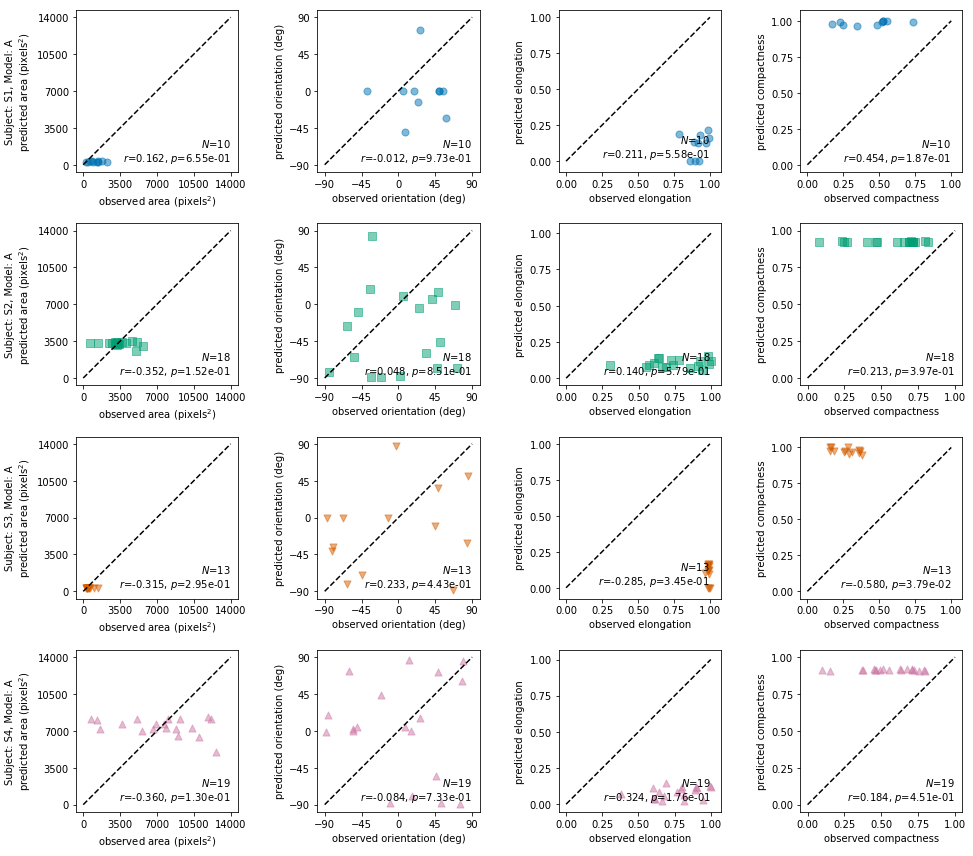

In [18]:
plotmodel = 'A'
fig, axes = plt.subplots(ncols=len(predcols), nrows=len(subjects), 
                         figsize=(14, 3 * len(subjects)))
for subject, marker, color, axrow in zip(subjects, markers, colors, axes):
    for _, row in best[np.logical_and(best['subject'] == subject, best['model'] == plotmodel)].iterrows():
        for col, ax, tick, lim, label in zip(predcols, axrow, ticks, limits, labels):
            y = row['y_test']
            y_pred = row['y_pred']
            ax.scatter(y[col], y_pred[col], marker=marker, s=50, c=color, alpha=0.5)
            ax.plot([tick[0], tick[1]], [tick[0], tick[1]], 'k--')
            ax.set_xticks(np.linspace(*tick, num=5))
            ax.set_yticks(np.linspace(*tick, num=5))
            ax.set_xlim(*lim)
            ax.set_ylim(*lim)
            ax.set_xlabel('observed %s' % label)
            ax.set_ylabel('predicted %s' % label)
            ax.axis('square')
            slope, intercept, rval, pval, _ = spst.linregress(y[col], y_pred[col])
            fve = sklm.explained_variance_score(y[col], y_pred[col])
            ax.text(tick[1], tick[0], "$N$=%d, $FVE$=%.3f\n$r$=%.3f, $p$=%.2e" % (len(y), fve, rval, pval), 
                    va='bottom', ha='right')
        break
    axrow[0].set_ylabel('Subject: %s, Model: %s\npredicted %s' % (subject, plotmodel, labels[0]))
fig.tight_layout()
fig.savefig('fig7-scatter-%s.eps' % plotmodel)

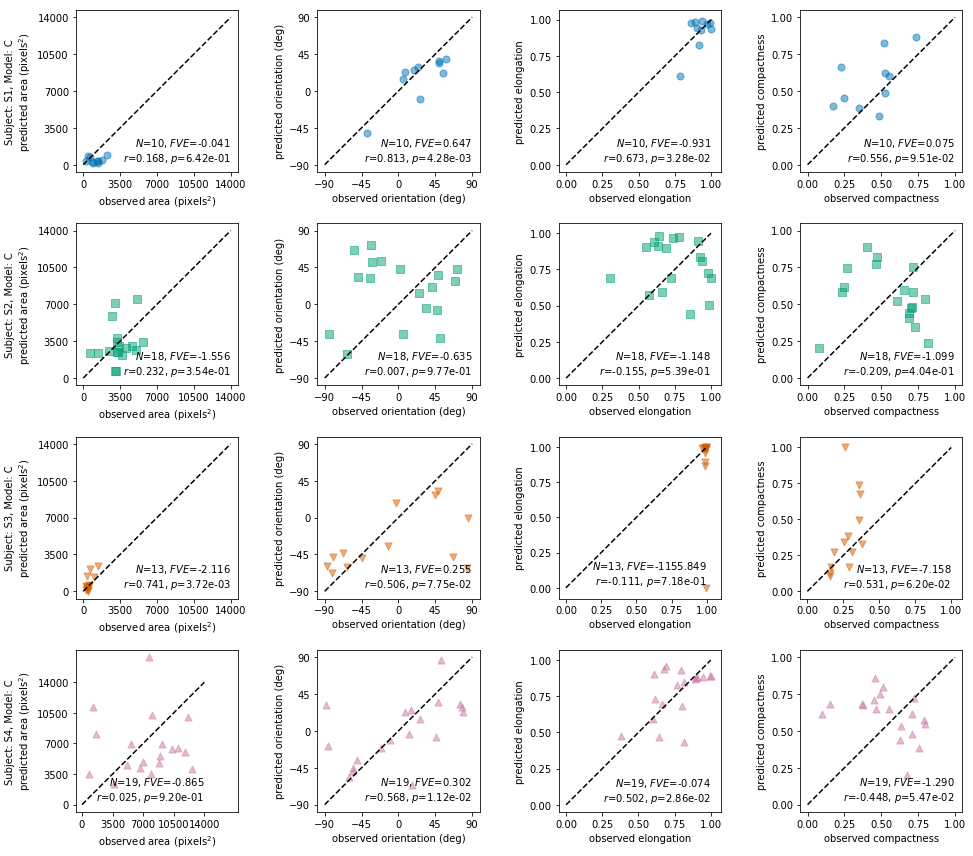

In [19]:
plotmodel = 'C'
fig, axes = plt.subplots(ncols=len(predcols), nrows=len(subjects), 
                         figsize=(14, 3 * len(subjects)))
for subject, marker, color, axrow in zip(subjects, markers, colors, axes):
    for _, row in best[np.logical_and(best['subject'] == subject, best['model'] == plotmodel)].iterrows():
        for col, ax, tick, lim, label in zip(predcols, axrow, ticks, limits, labels):
            y = row['y_test']
            y_pred = row['y_pred']
            ax.scatter(y[col], y_pred[col], marker=marker, s=50, c=color, alpha=0.5)
            ax.plot([tick[0], tick[1]], [tick[0], tick[1]], 'k--')
            ax.set_xticks(np.linspace(*tick, num=5))
            ax.set_yticks(np.linspace(*tick, num=5))
            ax.set_xlim(*lim)
            ax.set_ylim(*lim)
            ax.set_xlabel('observed %s' % label)
            ax.set_ylabel('predicted %s' % label)
            ax.axis('square')
            slope, intercept, rval, pval, _ = spst.linregress(y[col], y_pred[col])
            fve = sklm.explained_variance_score(y[col], y_pred[col])
            ax.text(tick[1], tick[0], "$N$=%d, $FVE$=%.3f\n$r$=%.3f, $p$=%.2e" % (len(y), fve, rval, pval), 
                    va='bottom', ha='right')
        break
    axrow[0].set_ylabel('Subject: %s, Model: %s\npredicted %s' % (subject, plotmodel, labels[0]))
fig.tight_layout()
fig.savefig('fig7-scatter-%s.eps' % plotmodel)
fig.savefig('fig7-scatter-%s.png' % plotmodel)

In [20]:
img_argus1 = skio.imread('/home/mbeyeler/Dropbox/UW/argus_i.jpg')
img_argus2 = skio.imread('/home/mbeyeler/Dropbox/UW/argus_ii.jpg')

In [21]:
px_argus1 = np.array([
    [  93.12857037,  162.32202802],
    [ 138.00952276,  163.7029804 ],
    [ 178.74761799,  163.01250421],
    [ 227.77142752,  161.63155183],
    [  93.12857037,  208.58393279],
    [ 143.53333228,  207.8934566 ],
    [ 182.89047514,  207.2029804 ],
    [ 227.77142752,  206.51250421],
    [  93.12857037,  251.3934566 ],
    [ 137.31904657,  251.3934566 ],
    [ 180.81904657,  251.3934566 ],
    [ 227.08095133,  251.3934566 ],
    [  93.81904657,  296.27440898],
    [ 140.08095133,  296.27440898],
    [ 182.89047514,  297.65536136],
    [ 227.08095133,  297.65536136]
])
px_argus1[:, 0] += 70
px_argus1[:, 1] -= 70

px_argus2 = np.array([
    [ 296.94026284,  140.58506571], [ 328.48148148,  138.4823178 ],
    [ 365.27956989,  140.58506571], [ 397.87216249,  139.53369176],
    [ 429.41338112,  138.4823178 ], [ 463.05734767,  140.58506571],
    [ 495.64994026,  139.53369176], [ 528.24253286,  139.53369176],
    [ 560.83512545,  139.53369176], [ 593.42771804,  138.4823178 ],
    [ 296.94026284,  173.1776583 ], [ 329.53285544,  174.22903226],
    [ 363.17682198,  173.1776583 ], [ 396.82078853,  173.1776583 ],
    [ 430.46475508,  173.1776583 ], [ 463.05734767,  174.22903226],
    [ 494.59856631,  173.1776583 ], [ 529.29390681,  174.22903226],
    [ 559.78375149,  175.28040621], [ 593.42771804,  173.1776583 ],
    [ 296.94026284,  206.82162485], [ 329.53285544,  206.82162485],
    [ 363.17682198,  205.7702509 ], [ 395.76941458,  205.7702509 ],
    [ 429.41338112,  205.7702509 ], [ 463.05734767,  208.92437276],
    [ 496.70131422,  207.87299881], [ 529.29390681,  209.97574671],
    [ 559.78375149,  208.92437276], [ 592.37634409,  206.82162485],
    [ 296.94026284,  240.4655914 ], [ 330.58422939,  240.4655914 ],
    [ 363.17682198,  240.4655914 ], [ 396.82078853,  240.4655914 ],
    [ 430.46475508,  240.4655914 ], [ 460.95459976,  240.4655914 ],
    [ 494.59856631,  242.56833931], [ 528.24253286,  239.41421744],
    [ 559.78375149,  240.4655914 ], [ 593.42771804,  241.51696535],
    [ 297.9916368 ,  274.10955795], [ 328.48148148,  273.05818399],
    [ 361.07407407,  274.10955795], [ 395.76941458,  273.05818399],
    [ 428.36200717,  274.10955795], [ 463.05734767,  273.05818399],
    [ 494.59856631,  275.1609319 ], [ 526.13978495,  274.10955795],
    [ 560.83512545,  274.10955795], [ 591.32497013,  274.10955795],
    [ 295.88888889,  306.70215054], [ 329.53285544,  305.65077658],
    [ 363.17682198,  305.65077658], [ 393.66666667,  307.75352449],
    [ 427.31063321,  307.75352449], [ 459.90322581,  305.65077658],
    [ 492.4958184 ,  308.80489845], [ 527.1911589 ,  307.75352449],
    [ 559.78375149,  307.75352449], [ 590.27359618,  306.70215054]
])

In [22]:
def plot_phosphenes_on_array(ax, subject, Xymu, subjectdata):
    Xymu = Xymu[Xymu.subject == subject]
    implant_type = subjectdata.loc[subject, 'implant_type']
    argus = implant_type(x_center=subjectdata.loc[subject, 'implant_x'],
                         y_center=subjectdata.loc[subject, 'implant_y'],
                         rot=subjectdata.loc[subject, 'implant_rot'])
    is_argus2 = isinstance(implant_type(), p2pi.ArgusII)
    if is_argus2:
        px_argus = px_argus2
        img_argus = img_argus2
    else:
        px_argus = px_argus1
        img_argus = img_argus1    
    
    padding = 2000
    x_range = (p2pr.ret2dva(np.min([e.x_center for e in argus]) - padding),
               p2pr.ret2dva(np.max([e.x_center for e in argus]) + padding))
    y_range = (p2pr.ret2dva(np.min([e.y_center for e in argus]) - padding),
               p2pr.ret2dva(np.max([e.y_center for e in argus]) + padding))
    out_shape = Xymu.img_shape.unique()[0]  # (np.diff(y_range)[0] * 10, np.diff(x_range)[0] * 10)
    pts_in = []
    pts_dva = []
    pts_out = []
    for xy, e in zip(px_argus, argus):
        pts_in.append(xy)
        dva = p2pr.ret2dva([e.x_center, e.y_center])
        pts_dva.append(dva)
        xout = (dva[0] - x_range[0]) / (x_range[1] - x_range[0]) * (out_shape[1] - 1)
        yout = (dva[1] - y_range[0]) / (y_range[1] - y_range[0]) * (out_shape[0] - 1)
        pts_out.append([xout, yout])
    argus2dva = skit.estimate_transform('similarity', np.array(pts_in), np.array(pts_dva))
    dva2out = skit.estimate_transform('similarity', np.array(pts_dva), np.array(pts_out))
    argus2out = skit.estimate_transform('similarity', np.array(pts_in), np.array(pts_out))
    
    # top left, top right, bottom left, bottom right
    pts_draw = [[0, 0], [0, out_shape[1] - 1],
                [out_shape[0] - 1, 0], [out_shape[1] - 1, out_shape[0] - 1]]
    x_range = subjectdata.loc[subject, 'xrange']
    y_range = subjectdata.loc[subject, 'yrange']
    pts_dva = [[x_range[0], y_range[0]], [x_range[0], y_range[1]],
               [x_range[1], y_range[0]], [x_range[1], y_range[1]]]
    draw2dva = skit.estimate_transform('similarity', np.array(pts_draw), np.array(pts_dva))

    all_imgs = np.zeros(out_shape)
    for _, row in Xymu.iterrows():
        e_pos = p2pr.ret2dva((argus[row['electrode']].x_center, argus[row['electrode']].y_center))
        align_center = dva2out(e_pos)[0]
        img_drawing = argus_shapes.imgproc.scale_phosphene(row['image'], subjectdata.loc[subject, 'scale'])
        img_drawing = argus_shapes.imgproc.center_phosphene(img_drawing, center=align_center[::-1])
        all_imgs += img_drawing
    all_imgs = np.maximum(0, np.minimum(1, 1 - all_imgs))
    ax.imshow(np.ma.masked_where(all_imgs > 0.5, all_imgs), vmin=0, vmax=1, cmap='gray')
    ax.imshow(skit.warp(img_argus, argus2out.inverse, cval=1.0, output_shape=out_shape), alpha=0.3)
    
    fovea = fovea = dva2out([0, 0])[0]
    ax.scatter(fovea[0], fovea[1], s=100, marker='s', c='w', edgecolors='k')

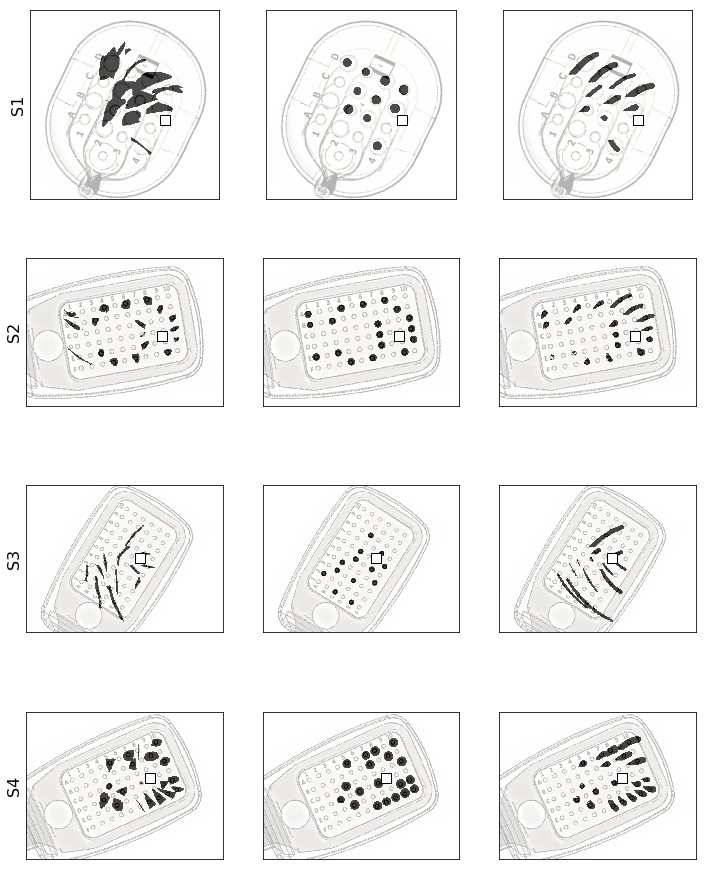

In [24]:
fig, axes = plt.subplots(nrows=len(subjects), ncols=3, figsize=(12, 4 * len(subjects)))
for subject, axrow in zip(subjects, axes):
    for model, col, ax in zip(['A', 'A', 'C'], ['y_test', 'y_pred', 'y_pred'], axrow):
        yp = best[np.logical_and(best['subject'] == subject, best['model'] == model)][col].values[0]
        yp['subject'] = pd.Series([subject for _, _ in yp.iterrows()], index=yp.index)
        plot_phosphenes_on_array(ax, subject, yp, subjectdata)
        ax.set_xticks([])
        ax.set_yticks([])
    axrow[0].set_ylabel(subject, fontsize=16)
fig.savefig('fig7-model-scatter.png')